In [1]:
import cvtk
import os
import sys
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

import re
import pickle

from tqdm import tqdm
from tqdm import tnrange
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import statsmodels.api as sm
import matplotlib as mpl

In [2]:
from cvtk.cvtk import TemporalFreqs, TiledTemporalFreqs
from cvtk.cov import stack_temporal_covariances
import cvtk.variant_files as vf
from cvtk.gintervals import GenomicIntervals
from cvtk.pca import FreqPCA
from cvtk.plots import rep_plot_pca, correction_diagnostic_plot
from cvtk.utils import integerize
from cvtk.utils import extract_empirical_nulls_diagonals, extract_temporal_cov_diagonals
from cvtk.cov import stack_replicate_covariances, stack_temporal_covs_by_group

In [3]:
%matplotlib inline
#%config InlineBackend.figure_format = 'svg'
mpl.rcParams['figure.figsize'] = (8.0, 4.0)
mpl.rcParams['figure.dpi'] = 200

In [4]:
np.random.seed(0)

In [17]:
# import vcf
## why "VariantFile with 0 loci and 0 samples"???????
from cvtk.variant_files import VCFFile
vcf = VCFFile('/gxfs_work/geomar/smomw426/cod3/09_selectVariants/cod3_filteredSNPs_gq20_dp8_ua_bial_miss08_meanDP10_hwe001_maf0.005_temp115/tempEBC_115_clean.vcf.gz')

reading file '/gxfs_work/geomar/smomw426/cod3/09_selectVariants/cod3_filteredSNPs_gq20_dp8_ua_bial_miss08_meanDP10_hwe001_maf0.005_temp115/tempEBC_115_clean.vcf.gz'...
file '/gxfs_work/geomar/smomw426/cod3/09_selectVariants/cod3_filteredSNPs_gq20_dp8_ua_bial_miss08_meanDP10_hwe001_maf0.005_temp115/tempEBC_115_clean.vcf.gz' loaded.
total time to load VCF file: 3.7068554123242694 mins.


In [18]:
# import population information a tab delimited file with sample name and temporal population name in each line for an individual in the vcf file
samples = pd.read_csv("/gxfs_work/geomar/smomw426/cod3/09_selectVariants/cod3_filteredSNPs_gq20_dp8_ua_bial_miss08_meanDP10_hwe001_maf0.005_temp115/pop_info_noHeader.txt", header=None, names = ('individual', 'line'), sep="\t")
samples

,individual,line
0,4-04-AL099-630_S4_L004,pop1996
1,20-20-AL101-185_S20_L004,pop1996
2,22-22-AL099-591_S22_L004,pop1996
3,23-23-AL129-369_S23_L004,pop1996
4,25-25-AL101-434_S25_L004,pop1996
...,...,...
110,J35421-S1-_L1_S118_L002,pop2019
111,J35422-S1-_L1_S119_L002,pop2019
112,J35429-S1-_L1_S126_L002,pop2019
113,J35430-S1-_L1_S127_L002,pop2019


In [19]:
sample_map = {k:v for k, v in zip(samples['individual'], samples['line'])}

In [20]:
from collections import defaultdict

subpop_indices = defaultdict(list)

for i, k in enumerate(vcf.samples):
    subpop_indices[sample_map[k.decode()]].append(i)

In [21]:
## this is where the population information for each sample is used to calculate counts then frequency later
## only after this function, vcf.calc_freqs works!!

#counts_mat = vcf.count_alleles_subpops(subpop_indices)
## this function raised an error "TypeError: arrays to stack must be passed as a "sequence" type such as list or tuple."
## so I assign each attribute one by one, to fix 
counts_mat=vcf.geno_mat.count_alleles_subpops(subpop_indices)
vcf.mat = np.stack(list(counts_mat.values()))
vcf.subpops = subpop_indices.keys()

In [22]:
##count ndiploids for each pop(timepoints)

from collections import Counter
ndiploids = [Counter(sample_map.values())[k] for k in vcf.subpops]
ndiploids=np.array(ndiploids)
#ndiploids = np.array([24, 29, 22, 20, 20])
## sample number for each time points, in order of 2008,1996,2002,2014,2019


In [23]:
freq_mat_all = vcf.calc_freqs()
print("number of loci: ", freq_mat_all.shape[1])
vcf.remove_fixed()
freq_mat = vcf.calc_freqs()
print("number of loci: ", freq_mat.shape[1])
#number of loci:  5847389
print("loci not segregating removed: ", freq_mat_all.shape[1] - freq_mat.shape[1])
#loci not segregating removed:  11749
print(freq_mat.shape)
freq_mat

number of loci:  5847389
number of loci:  5835640
loci not segregating removed:  11749
(5, 5835640)


array([[1.        , 1.        , 1.        , ..., 0.97826087, 1.        ,
        0.97916667],
       [0.98148148, 0.98076923, 0.98148148, ..., 1.        , 0.97826087,
        0.97916667],
       [1.        , 1.        , 1.        , ..., 1.        , 1.        ,
        1.        ],
       [1.        , 1.        , 1.        , ..., 1.        , 1.        ,
        1.        ],
       [1.        , 1.        , 1.        , ..., 1.        , 0.96666667,
        1.        ]])

In [24]:
#freqs=freq_mat
#np.save('freq_mat',freq_mat)
## in file 'freq_mat.npy'  column order : 2008,1996,2002,2014,2019
freqs= np.load('freq_mat.npy')
freqs

array([[1.        , 1.        , 1.        , ..., 0.97826087, 1.        ,
        0.97916667],
       [0.98148148, 0.98076923, 0.98148148, ..., 1.        , 0.97826087,
        0.97916667],
       [1.        , 1.        , 1.        , ..., 1.        , 1.        ,
        1.        ],
       [1.        , 1.        , 1.        , ..., 1.        , 1.        ,
        1.        ],
       [1.        , 1.        , 1.        , ..., 1.        , 0.96666667,
        1.        ]])

In [25]:
#depths = vcf.N
#np.save('depths_vcf.N',vcf.N)
## in file 'depths_vcf.N.npy'  column order : 2008,1996,2002,2014,2019
depths = np.load('depths_vcf.N.npy')

In [26]:
gi = vcf.build_gintervals()


In [27]:
# save gi object to load later
with open('gi', 'wb') as gi_file:
   pickle.dump(gi, gi_file)

In [16]:
# to load the gi file
# with open('gi', 'rb') as gi_file:
#    gi = pickle.load(gi_file)

EOFError: Ran out of input

In [28]:
tile_width = 1e5
gi.infer_seqlens()
tiles = GenomicIntervals.from_tiles(gi.seqlens, width=tile_width)
print(tiles)

GenomicIntervals — 43 unique seqids, 6569 features
                  GenomicInterval
0       NC_044048.1:[0, 100000.0)
1  NC_044048.1:[100000, 200000.0)
2  NC_044048.1:[200000, 300000.0)
3  NC_044048.1:[300000, 400000.0)
4  NC_044048.1:[400000, 500000.0)
[ 6564 more GenomicIntervals ]


In [29]:
#'pop' field has to be same name for TiledTemporalFreqs to recognize that they are temporal groups
design = [  ('pop',0),
            ('pop',1),
            ('pop',2),
            ('pop',3),
            ('pop',4) ]
design

## change the order of the frequency matrix as well as depth matrix , number of samples for each population (ndiploids)
freqs = freqs[[1,2,0,3,4],:]
depths = depths[[1,2,0,3,4],:]
ndiploids = ndiploids[[1,2,0,3,4]]
print(ndiploids)#check the order 

d = TiledTemporalFreqs(tiles, freqs=freqs, depths=depths, diploids=ndiploids, samples=design, gintervals=gi)
d.freqs.shape

[29 22 24 20 20]


(1, 5, 5835640)

In [5]:
# save d object to load later
# with open('d_tiled', 'wb') as d_file:
#    pickle.dump(d, d_file)
# to load the d file
with open('d_tiled', 'rb') as d_file:
    d = pickle.load(d_file)

In [30]:
d.samples

[('pop', 0), ('pop', 1), ('pop', 2), ('pop', 3), ('pop', 4)]

In [8]:
print(np.amax(d.depths.flatten()))
print(np.amin(d.depths.flatten()))

58
8


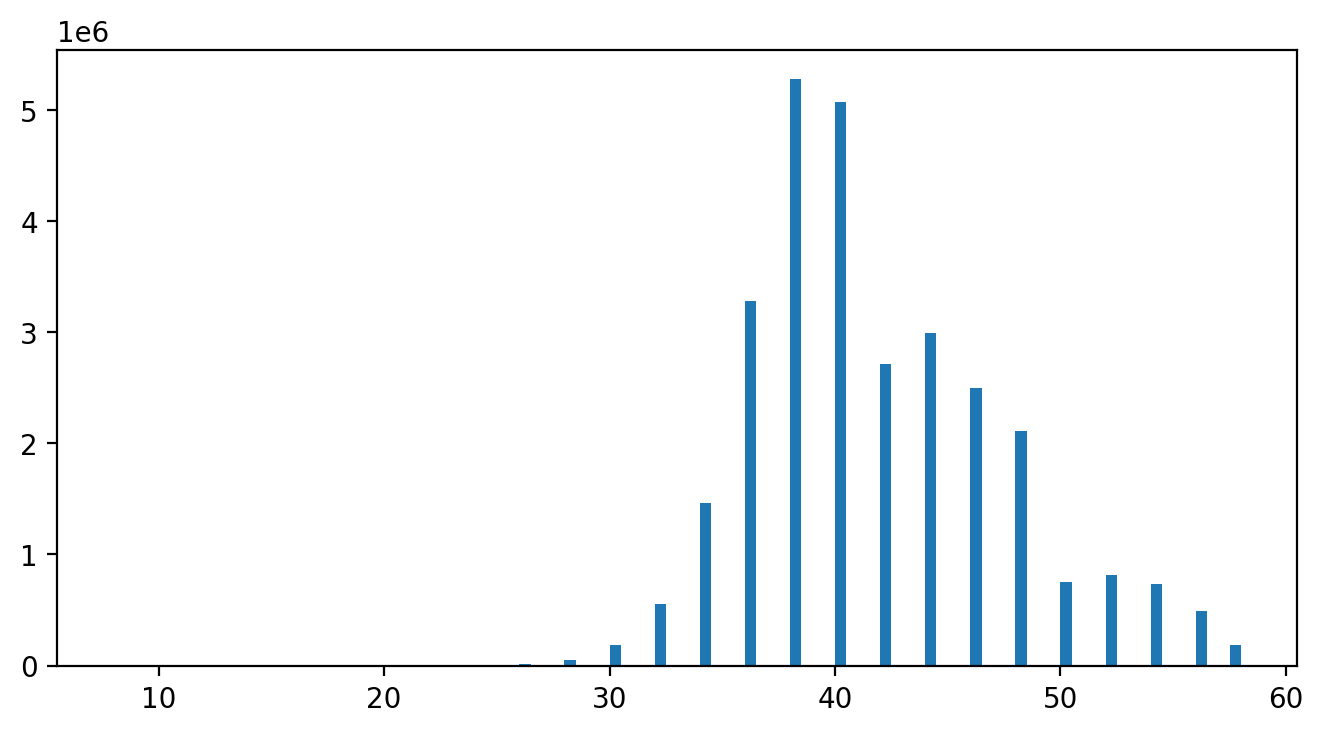

In [9]:
plt.hist(d.depths.flatten(),100)
plt.show()

In [10]:
## How many windows and what's the mean and median number of loci per window?

nloci = np.array([len(x) for x in d.tile_indices])

d_noempty = [ele for ele in d.tile_indices if ele != []]
print(len(d_noempty))
print(len(d.tile_indices))

print(f"mean number of loci: {nloci.mean()}")
print(f"median number of loci: {np.median(nloci)}")

6454
6569
mean number of loci: 881.4792205815193
median number of loci: 907.0


In [31]:
gw_covs = d.calc_cov(bias_correction=True)

In [32]:
gw_covs.shape

(4, 4)

In [33]:
gw_covs

array([[-0.04721835,  0.02731489, -0.00060104,  0.00134311],
       [ 0.02731489, -0.04915612,  0.02405939, -0.00164922],
       [-0.00060104,  0.02405939, -0.05056121,  0.02610428],
       [ 0.00134311, -0.00164922,  0.02610428, -0.05813607]])

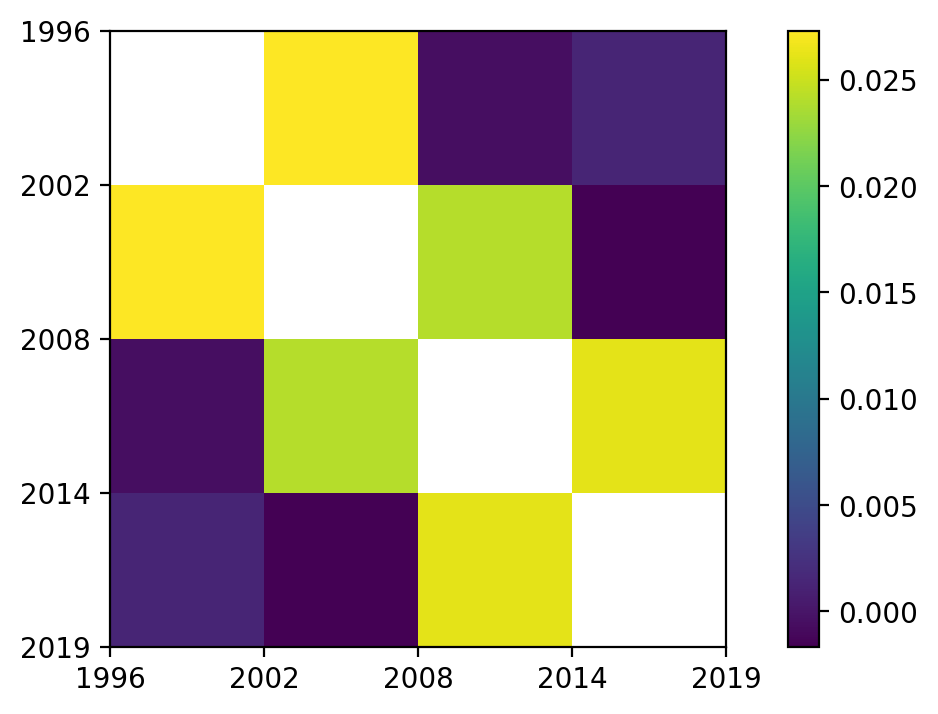

In [13]:
np.fill_diagonal(gw_covs, np.nan)
fig, ax = plt.subplots()
ax.imshow(gw_covs)
img1 = ax.imshow(gw_covs)
fig.colorbar(img1, ax=ax)
sample_names = ['1996','2002','2008','2014','2019' ]
ax.set_xticks(np.arange(len(sample_names))-0.5)
ax.set_yticks(np.arange(len(sample_names))-0.5)

ax.set_xticklabels(sample_names)
ax.set_yticklabels(sample_names)
#print( design['name'])
#plt.savefig('covariance_heatmap.pdf')

plt.show()

In [6]:
## bootstrap covariance matrix
from tqdm import tqdm
from tqdm import tnrange
# need to use CI method "standard" to deal with bias in the bootstrap
gw_covs_cis = d.bootstrap_cov(B=1000, progress_bar=True, keep_seqids=None,
                              average_replicates=False, use_masked=True)
#ci_method="standard"


/gxfs_work/geomar/smomw426/cod3/15_temp_cov/cvtkpy/cvtk/cov.py:316: RuntimeWarning: Mean of empty slice
  mean_hets = np.nanmean(hets, axis=freqs.ndim-1)
/gxfs_work/geomar/smomw426/cod3/15_temp_cov/cvtkpy/cvtk/cov.py:375: RuntimeWarning: Mean of empty slice
  ave_bias += np.nanmean(0.5 * hets * (diploid_correction + depth_correction), axis=2)


bootstraps:   0%|          | 0/1000 [00:00<?, ?it/s]

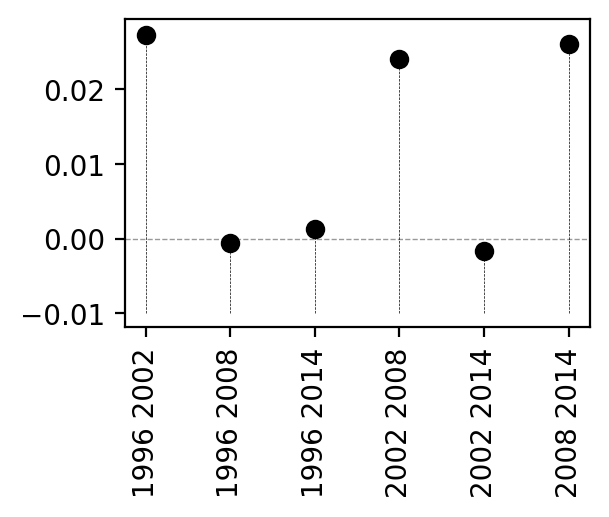

In [16]:
def rep_cov_plot(cis, labels='', filename=''):
    rows, cols = np.triu_indices(cis.shape[1], k=1)
    lower, mean, upper = [cis[i, rows, cols].ravel() for i in np.arange(3)]
    all_labels = [labels[i] + " " + labels[j] for i, j in zip(rows, cols)]
    lower, upper = mean-lower, upper-mean
    bounds = np.stack([lower, upper])
    plt.figure(figsize=(3,2)) 
    plt.axhline(y=0, c='0.6', linewidth=0.5, zorder=-1, linestyle='--')
    plt.xticks(rotation='vertical',fontsize=10)
    markerline, stemline, baseline, = plt.stem(all_labels, mean,linefmt='k--', bottom = -0.01)
    plt.setp(stemline, linewidth = 0.25)
    plt.setp(baseline, 'linewidth', 0)
    #plt.ylim([-0.01, 0.065])
    #plt.errorbar(all_labels, mean, yerr=bounds, capsize=0, fmt='o', linewidth=1.5, elinewidth=2)
    plt.errorbar(all_labels, mean, yerr=bounds, capsize=0, fmt='none', linewidth=1, elinewidth=1, ecolor = "black")
    plt.savefig(filename, bbox_inches='tight')

sample_names = ['1996','2002','2008','2014','2019' ]
rep_cov_plot(gw_covs_cis, sample_names,"./covariance_pairwise.pdf")

In [7]:
diagnostics = d.correction_diagnostics(exclude_seqids=None)

/gxfs_work/geomar/smomw426/cod3/15_temp_cov/cvtkpy/cvtk/cvtk.py:260: RuntimeWarning: Mean of empty slice
  n = np.nanmean(n)
/gxfs_work/geomar/smomw426/cod3/15_temp_cov/cvtkpy/cvtk/cvtk.py:274: RuntimeWarning: Mean of empty slice
  het = np.nanmean(het)
/gxfs_home/geomar/smomw426/.conda/envs/myjupyterlabenv/lib/python3.10/site-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/gxfs_home/geomar/smomw426/.conda/envs/myjupyterlabenv/lib/python3.10/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/gxfs_work/geomar/smomw426/cod3/15_temp_cov/cvtkpy/cvtk/cov.py:348: RuntimeWarning: Degrees of freedom <= 0 for slice
  cov = np.cov(deltas, bias=True)
/gxfs_home/geomar/smomw426/.conda/envs/myjupyterlabenv/lib/python3.10/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/gxfs_home/geoma

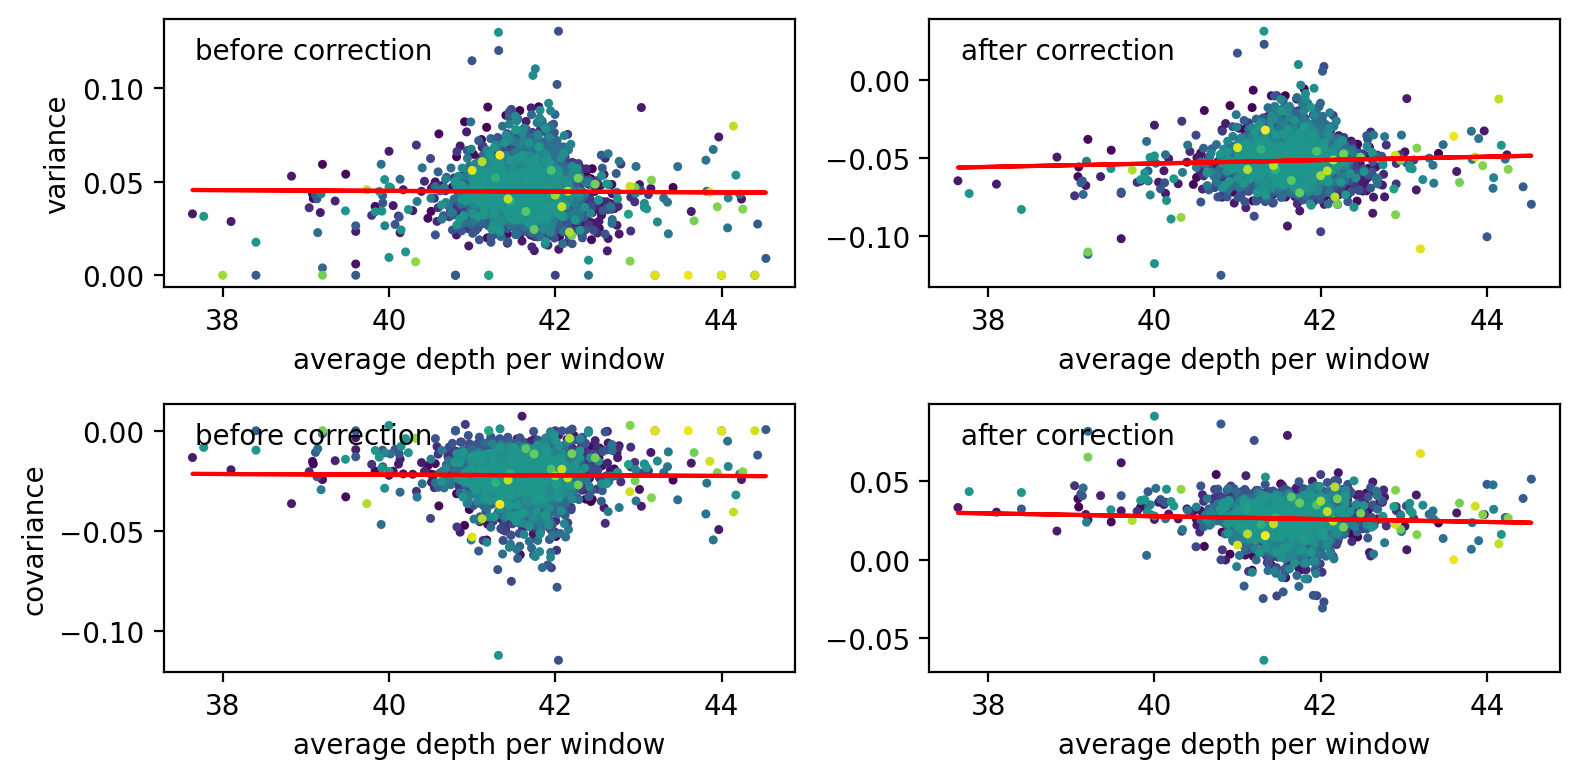

In [8]:
# _ = correction_diagnostic_plot(diagnostics, color=False)
# diagnostic plot from package threw error.
def correction_diagnostic_plot(diag, figsize=None, color=True):
    corr_df, models, xpreds, ypreds = diag
    if figsize is not None:
        fig, ax = plt.subplots(ncols=2, nrows=2, figsize=figsize)
    else:
        fig, ax = plt.subplots(ncols=2, nrows=2)
    labelx, labely = 0.05, 0.85
    before = corr_df[corr_df['correction'] == False]
    after = corr_df[corr_df['correction'] == True]
    if color:
        ax[0, 0].scatter(before['depth'], before['diag'], c=integerize(before['seqid']), s=5)
        ax[0, 1].scatter(before['depth'], after['diag'], c=integerize(before['seqid']), s=5)
    else:
        ax[0, 0].scatter(before['depth'], before['diag'], s=5)
        ax[0, 1].scatter(before['depth'], after['diag'], s=5)
    ax[0, 0].plot(xpreds[False], ypreds[False][0], 'r-')
    ax[0, 1].plot(xpreds[True], ypreds[True][0], 'r-')
    ax[0, 0].annotate('before correction', xy=(labelx, labely), xycoords='axes fraction')
    ax[0, 0].set_ylabel('variance')
    ax[0, 0].set_xlabel('average depth per window')
    ax[0, 1].set_xlabel('average depth per window')
    ax[0, 1].annotate('after correction', xy=(labelx, labely), xycoords='axes fraction')

    ax[1, 0].plot(xpreds[False], ypreds[False][1], 'r-')
    ax[1, 0].annotate('before correction', xy=(labelx, labely), xycoords='axes fraction')
#    ax[1, 0].axhline(y=0, color='99', zorder=1, linestyle='--')
    ax[1, 0].set_ylabel('covariance')
    if color:
        ax[1, 0].scatter(before['depth'], before['offdiag'], c=integerize(before['seqid']),
                         zorder=2, s=5)
        ax[1, 1].scatter(before['depth'], after['offdiag'], c=integerize(before['seqid']),
                         zorder=2, s=5)
    else:
        ax[1, 0].scatter(before['depth'], before['offdiag'], zorder=2, s=5)
        ax[1, 1].scatter(before['depth'], after['offdiag'], zorder=2, s=5)
    ax[1, 1].plot(xpreds[True], ypreds[True][1], 'r-')
    ax[1, 1].annotate('after correction', xy=(labelx, labely), xycoords='axes fraction')
 #   ax[1, 1].axhline(y=0, color='99', zorder=1, linestyle='--')
    ax[1, 0].set_xlabel('average depth per window')
    ax[1, 1].set_xlabel('average depth per window')
    plt.tight_layout()
    return fig, ax

_ = correction_diagnostic_plot(diagnostics, color=True)

In [35]:
megabase_tiles = GenomicIntervals.from_tiles(d.gintervals.seqlens, width=1e6)
d.set_tiles(megabase_tiles)
print("number of blocks: ", len(d.tile_indices))

number of blocks:  639


In [36]:
gw_temp_covs_cis = d.bootstrap_cov(B=5000, use_masked=True, progress_bar=True)

bootstraps:   0%|          | 0/5000 [00:00<?, ?it/s]

In [37]:
gw_temp_covs_cis

array([[[-0.04763039,  0.0269286 , -0.00098566,  0.00076235],
        [ 0.0269286 , -0.04968331,  0.0233568 , -0.00215589],
        [-0.00098566,  0.0233568 , -0.05123368,  0.02561536],
        [ 0.00076235, -0.00215589,  0.02561536, -0.05890856]],

       [[-0.04721835,  0.02731489, -0.00060104,  0.00134311],
        [ 0.02731489, -0.04915612,  0.02405939, -0.00164922],
        [-0.00060104,  0.02405939, -0.05056121,  0.02610428],
        [ 0.00134311, -0.00164922,  0.02610428, -0.05813607]],

       [[-0.04675698,  0.02768476, -0.00020156,  0.00188656],
        [ 0.02768476, -0.04865236,  0.02469235, -0.00110654],
        [-0.00020156,  0.02469235, -0.0498736 ,  0.02666956],
        [ 0.00188656, -0.00110654,  0.02666956, -0.05740115]]])

In [22]:
# with open(f'./cod3_tile_temporal_covs_1e5.npy', 'wb') as f:
#     np.save(f, gw_temp_covs_cis)

In [9]:
# gw_temp_covs_cis = np.load('./cod3_tile_temporal_covs_1e5.npy')

In [38]:
gw_temp_covs_cis.shape

(3, 4, 4)

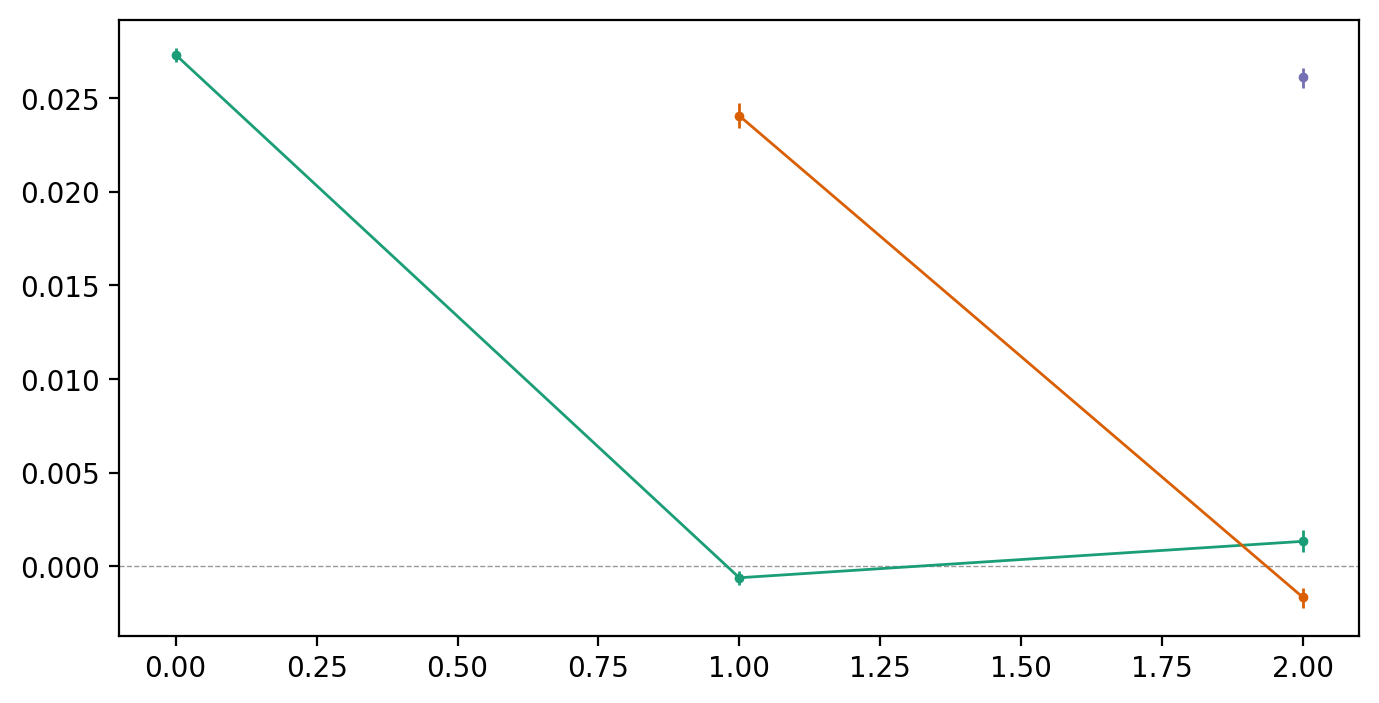

In [39]:
def cov_plot(cov_cis, ax=None, alpha=1, error_alpha=1, ngens=1, linewidth=1, ylim=None, xlim=None, hline=True, 
             cmap=cm.Dark2, y_multiplier=None, xticks=None, ylab=None):
    if ax is None:
        fig, ax = plt.subplots()
    _, T, T = cov_cis.shape
    y_multiplier = y_multiplier if y_multiplier is not None else 1
    for refgen in range(T):
        x = np.arange(refgen, T) 
        mean = y_multiplier*cov_cis[1][refgen, (refgen+1):]
        lower, upper = y_multiplier*cov_cis[0][refgen, (refgen+1):]-mean, mean-y_multiplier*cov_cis[2][refgen, (refgen+1):]
        
        #ax.plot(np.broadcast_to(ngens*np.arange(refgen, T), (2, T-refgen)), temp_covs_bs[(0, 2), refgen, refgen:])
        ax.plot(x[:-1], mean, '-o', linewidth=linewidth, solid_capstyle='round', alpha=alpha, c=cmap(refgen), 
                label=refgen, zorder=refgen, markersize=2.5) #markersize=3.5)#, markeredgecolor='w')
        #ax.plot(x[:-1], mean, 'o', linewidth=linewidth, solid_capstyle='round', alpha=alpha, c=cmap(refgen), 
        #        label=refgen, zorder=refgen) #markersize=4.3)# markeredgecolor='w')
        ax.errorbar(x[:-1], mean, yerr=np.column_stack([lower.ravel(), upper.ravel()]).T, 
                    capsize=0, elinewidth=linewidth, c=cmap(refgen), 
                    linewidth=0,
                    zorder=100+refgen, alpha=error_alpha, label=None, solid_capstyle='round')

    if ylim is not None:
        plt.ylim(ylim)
    
    if xlim is not None:
        plt.xlim(xlim)
    #plt.xticks(np.arange(0, T*ngens, 10))
    if xticks is not None:
        plt.xticks(xticks)
    if hline:
        ax.axhline(y=0, c='0.6', linewidth=0.5, zorder=-1e6, linestyle='--')
    
    if ylab is None:
        ylab = "covariance"
        if y_multiplier is not None:
            ylab += f"  $(\\times 10^{{{int(np.log10(1/y_multiplier))}}})$"
    return fig, ax

fig, ax = cov_plot(gw_temp_covs_cis)
plt.savefig('cod3_covariance_plot.pdf')
#ax.set_ylim(-0.01, 0.01)

In [45]:
np.unique(np.array(gi.seqid))

array(['NC_002081.1', 'NC_044048.1', 'NC_044049.1', 'NC_044050.1',
       'NC_044051.1', 'NC_044052.1', 'NC_044053.1', 'NC_044054.1',
       'NC_044055.1', 'NC_044056.1', 'NC_044057.1', 'NC_044058.1',
       'NC_044059.1', 'NC_044060.1', 'NC_044061.1', 'NC_044062.1',
       'NC_044063.1', 'NC_044064.1', 'NC_044065.1', 'NC_044066.1',
       'NC_044067.1', 'NC_044068.1', 'NC_044069.1', 'NC_044070.1',
       'NW_021963949.1', 'NW_021963950.1', 'NW_021963951.1',
       'NW_021963952.1', 'NW_021963953.1', 'NW_021963955.1',
       'NW_021963957.1', 'NW_021963958.1', 'NW_021963959.1',
       'NW_021963960.1', 'NW_021963961.1', 'NW_021963962.1',
       'NW_021963963.1', 'NW_021963966.1', 'NW_021963968.1',
       'NW_021963969.1', 'NW_021963970.1', 'NW_021963971.1',
       'NW_021963972.1', 'NW_021963975.1', 'NW_021963976.1',
       'NW_021963977.1', 'NW_021963978.1', 'NW_021963979.1',
       'NW_021963980.1', 'NW_021963981.1', 'NW_021963982.1',
       'NW_021963983.1', 'NW_021963984.1', 'NW_02

In [46]:
#what if exclude inversion regions? 
#list(set(d.gintervals.keys()))
seqid = ['NC_002081.1', 'NC_044048.1', 'NC_044049.1', 'NC_044050.1','NC_044051.1', 'NC_044052.1', 'NC_044053.1', 'NC_044054.1','NC_044055.1', 'NC_044056.1', 'NC_044057.1', 'NC_044058.1','NC_044059.1', 'NC_044060.1', 'NC_044061.1', 'NC_044062.1','NC_044063.1', 'NC_044064.1', 'NC_044065.1', 'NC_044066.1','NC_044067.1', 'NC_044068.1', 'NC_044069.1', 'NC_044070.1']
# exclude the whole chromosome
keep_seqids = [chr for chr in seqid if chr not in ('NC_044048.1', 'NC_044053.1', 'NC_044058.1')]

d = TiledTemporalFreqs(tiles, freqs=freqs, depths=depths, diploids=ndiploids, samples=design, gintervals=gi)
gw_covs = d.calc_cov(bias_correction=True,keep_seqids=keep_seqids)

covs_noinv_cis = d.bootstrap_cov(B=5000, keep_seqids=keep_seqids, 
                                              average_replicates=False, progress_bar=True, use_masked=True)


/gxfs_work/geomar/smomw426/cod3/15_temp_cov/cvtkpy/cvtk/cov.py:316: RuntimeWarning: Mean of empty slice
  mean_hets = np.nanmean(hets, axis=freqs.ndim-1)
/gxfs_work/geomar/smomw426/cod3/15_temp_cov/cvtkpy/cvtk/cov.py:375: RuntimeWarning: Mean of empty slice
  ave_bias += np.nanmean(0.5 * hets * (diploid_correction + depth_correction), axis=2)


bootstraps:   0%|          | 0/5000 [00:00<?, ?it/s]

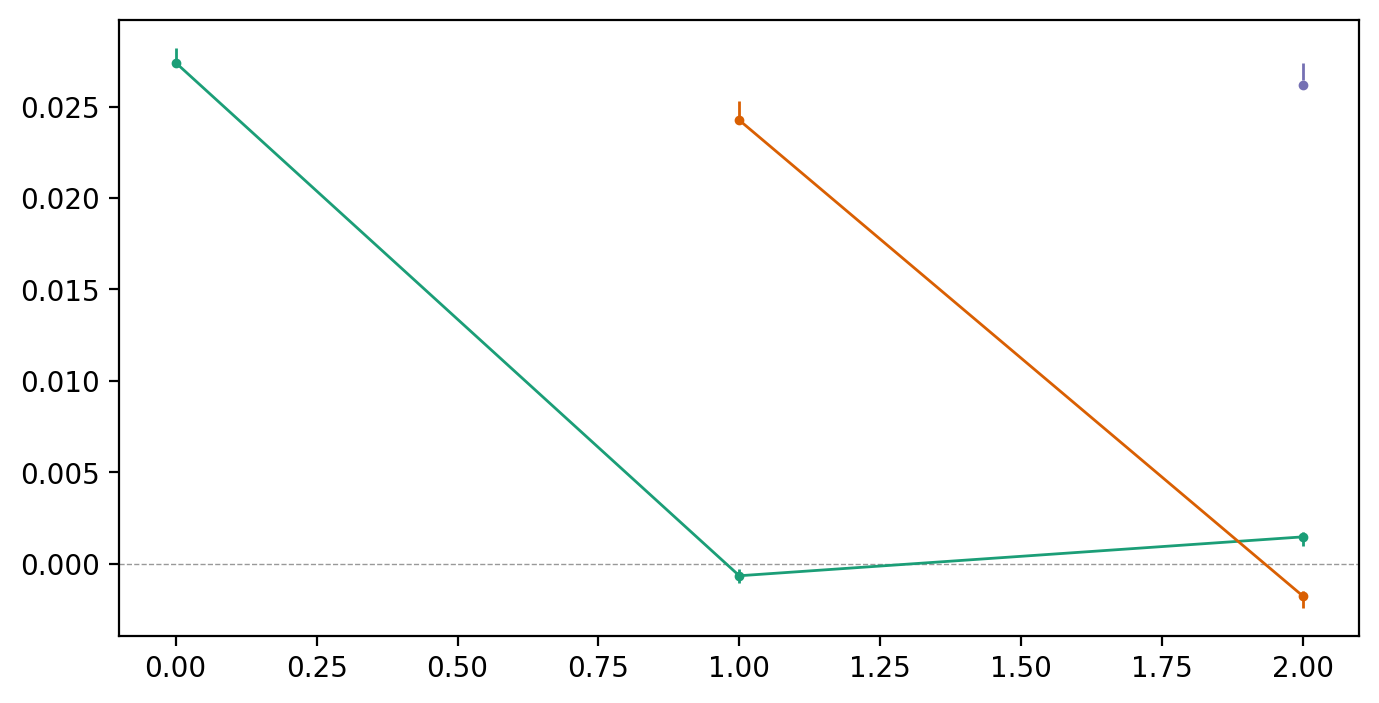

In [47]:
fig, ax = cov_plot(covs_noinv_cis)
plt.savefig('cod3_covariance_plot_noinv.pdf')